In [34]:
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Subset, DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [35]:
to_tensor = transforms.ToTensor()

class GrayScaleToColorTransform:

    def __call__(self, img):
        return to_tensor(img.convert('L')), to_tensor(img)

In [36]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_dataset = torchvision.datasets.ImageFolder(root='/kaggle/input/landscape-image-colorization/landscape Images/', transform=transform)

In [37]:
(gs_img, rgb_img), _ = image_dataset[0]  # _ is the image class which we don't need for this assignment

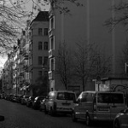

In [38]:
transforms.functional.to_pil_image(gs_img)

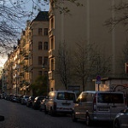

In [39]:
transforms.functional.to_pil_image(rgb_img)

In [40]:
print(len(image_dataset))

14258


# Tasks:

1. Build a custo [AutoEncoder] NN model. The input to the model is the Gray Scale Image and it's output should be colored image.
2. Split the data into training and validation splits (80%, 20%). Train the model on training data.
3. After training, show final loss value as well as draw a plot to show how loss dropped during training (both train and val loss).
4. Manually show the model's performance. Pick 3 random grayscale image, and RGB img pairs from the **val dataset** and for each of the grayscale image, show the grayscale img, the RGB image, and the model output image.

In [41]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# def trans_conv_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2),
#         nn.BatchNorm2d(out_channels),
#         nn.ReLU(inplace=True)
#     )

In [42]:
class encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x1 = self.conv_block1(x)
        x2 = self.conv_block2(x1)
        x3 = self.maxpool(x2)
        return x3, x2

In [43]:
class decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block1 = conv_block(in_channels, out_channels)
        self.conv_block2 = conv_block(out_channels, out_channels)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x, enc, dropout=False):
        x = self.trans_conv(x)
        x = torch.cat([x, enc], dim=1)
        if dropout: x = self.dropout(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return x

In [44]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = encoder(1, 64)
        self.enc2 = encoder(64, 128)
        self.enc3 = encoder(128, 256)
        self.enc4 = encoder(256, 512)

        self.bottleneck = nn.Sequential(
            conv_block(512, 1024),
            conv_block(1024, 1024)
        )

        self.dec1 = decoder(1024, 512)
        self.dec2 = decoder(512, 256)
        self.dec3 = decoder(256, 128)
        self.dec4 = decoder(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1, padding=0)

    def forward(self, x):
        x, enc1 = self.enc1(x)
        x, enc2 = self.enc2(x)
        x, enc3 = self.enc3(x)
        x, enc4 = self.enc4(x)

        x = self.bottleneck(x)

        x = self.dec1(x, enc4, dropout=True)
        x = self.dec2(x, enc3, dropout=True)
        x = self.dec3(x, enc2, dropout=True)
        x = self.dec4(x, enc1, dropout=True)

        x = self.final(x)

        return x

In [45]:
train_set, val_set = torch.utils.data.random_split(image_dataset, [0.8, 0.2])

In [46]:
import os
from PIL import Image
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, img) for img in os.listdir(root)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, 0

In [47]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    GrayScaleToColorTransform()
])

image_set = MyDataset(root='/kaggle/input/landscape-image-colorization/landscape Images/color', transform=transform)

train_set, val_set = torch.utils.data.random_split(image_set, [0.8, 0.2])

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [48]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

lr=1e-3
weight_decay=1e-2
num_epochs=20
criterion=nn.L1Loss()

optimizer=optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [49]:
# Defining the training function
def train(model, epochs, optimizer, criterion, device, scheduler=None):
    # Lists to keep track of the losses for plotting later
    val_losses = []
    train_losses = []

    # Iterating over epochs
    for epoch_num in range(epochs):
        model.train() # Sets the model in training mode

        epoch_losses = 0

        # Looping over batches for each epoch
        for (batch_x, batch_y), _ in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            batch_y_preds = model(batch_x) # Forward pass

            loss = criterion(batch_y_preds, batch_y) # Calculating the loss per batch

            optimizer.zero_grad()
            loss.backward() # Backwards pass
            optimizer.step() # Updating parameters

            epoch_losses += (len(batch_y)*loss.item()) # Keeping track of the losses per batch

        epoch_loss = epoch_losses/len(train_loader.dataset)
        train_losses.append(epoch_loss) # Keeping training track of the loss per epoch

        model.eval() # Sets the model in evaluation mode for validation
        correctly_labelled = 0
        with torch.no_grad(): # Disables gradient calculation
            val_epoch_losses = 0
            for (val_batch_x, val_batch_y), _ in val_loader:
                val_batch_x = val_batch_x.to(device)
                val_batch_y = val_batch_y.to(device)

                val_batch_y_preds = model(val_batch_x) # Predictions
                val_loss = criterion(val_batch_y_preds, val_batch_y)
                val_epoch_losses += (len(val_batch_y)*val_loss.item())

            val_epoch_loss = val_epoch_losses/len(val_loader.dataset)
            val_losses.append(val_epoch_loss) # Tracking epoch validation loss

        if scheduler:
            scheduler.step() # Updating the learning rate scheduler if one was provided
            print(f'Epoch: {epoch_num+1}/{epochs}, learning_rate={optimizer.param_groups[0]["lr"]:.6f} train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
        else:
            print(f'Epoch: {epoch_num+1}/{epochs}, train_loss={epoch_loss:.4f}, val_loss={val_epoch_loss:.4f}.')
    print('Training Done')
    return train_losses, val_losses # Returns the losses in order to keep track of them

In [50]:
# Function to plot the training losses and validation losses vs epochs. This will help identify overfitting and model performance
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross Entropy)')
    plt.legend()
    plt.show()

In [51]:
%%time

# Training the model
train_losses = []
val_losses = []

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/20, learning_rate=0.000900 train_loss=0.1150, val_loss=0.1000.
Epoch: 2/20, learning_rate=0.000810 train_loss=0.0629, val_loss=0.0820.
Epoch: 3/20, learning_rate=0.000729 train_loss=0.0618, val_loss=0.0974.
Epoch: 4/20, learning_rate=0.000656 train_loss=0.0601, val_loss=0.0693.
Epoch: 5/20, learning_rate=0.000590 train_loss=0.0596, val_loss=0.0831.
Epoch: 6/20, learning_rate=0.000531 train_loss=0.0582, val_loss=0.0819.
Epoch: 7/20, learning_rate=0.000478 train_loss=0.0573, val_loss=0.0632.
Epoch: 8/20, learning_rate=0.000430 train_loss=0.0562, val_loss=0.0636.
Epoch: 9/20, learning_rate=0.000387 train_loss=0.0571, val_loss=0.0667.
Epoch: 10/20, learning_rate=0.000349 train_loss=0.0574, val_loss=0.0791.
Epoch: 11/20, learning_rate=0.000314 train_loss=0.0562, val_loss=0.0590.
Epoch: 12/20, learning_rate=0.000282 train_loss=0.0558, val_loss=0.0586.
Epoch: 13/20, learning_rate=0.000254 train_loss=0.0557, val_loss=0.0755.
Epoch: 14/20, learning_rate=0.000229 train_loss=0.0556, val_

In [52]:
%%time

cycle_train_losses, cycle_val_losses = train(model, num_epochs, optimizer, criterion, device, scheduler=scheduler)

train_losses += cycle_train_losses
val_losses += cycle_val_losses

Epoch: 1/20, learning_rate=0.000109 train_loss=0.0537, val_loss=0.0632.
Epoch: 2/20, learning_rate=0.000098 train_loss=0.0541, val_loss=0.0541.
Epoch: 3/20, learning_rate=0.000089 train_loss=0.0532, val_loss=0.0542.
Epoch: 4/20, learning_rate=0.000080 train_loss=0.0530, val_loss=0.0594.
Epoch: 5/20, learning_rate=0.000072 train_loss=0.0531, val_loss=0.0516.
Epoch: 6/20, learning_rate=0.000065 train_loss=0.0531, val_loss=0.0532.
Epoch: 7/20, learning_rate=0.000058 train_loss=0.0527, val_loss=0.0530.
Epoch: 8/20, learning_rate=0.000052 train_loss=0.0522, val_loss=0.0507.
Epoch: 9/20, learning_rate=0.000047 train_loss=0.0526, val_loss=0.0497.
Epoch: 10/20, learning_rate=0.000042 train_loss=0.0520, val_loss=0.0508.
Epoch: 11/20, learning_rate=0.000038 train_loss=0.0521, val_loss=0.0481.
Epoch: 12/20, learning_rate=0.000034 train_loss=0.0513, val_loss=0.0474.
Epoch: 13/20, learning_rate=0.000031 train_loss=0.0517, val_loss=0.0492.
Epoch: 14/20, learning_rate=0.000028 train_loss=0.0507, val_

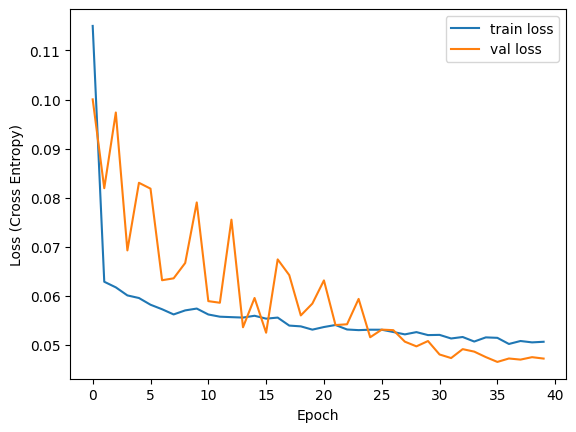

In [53]:
plot_losses(train_losses, val_losses)

In [54]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale, cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

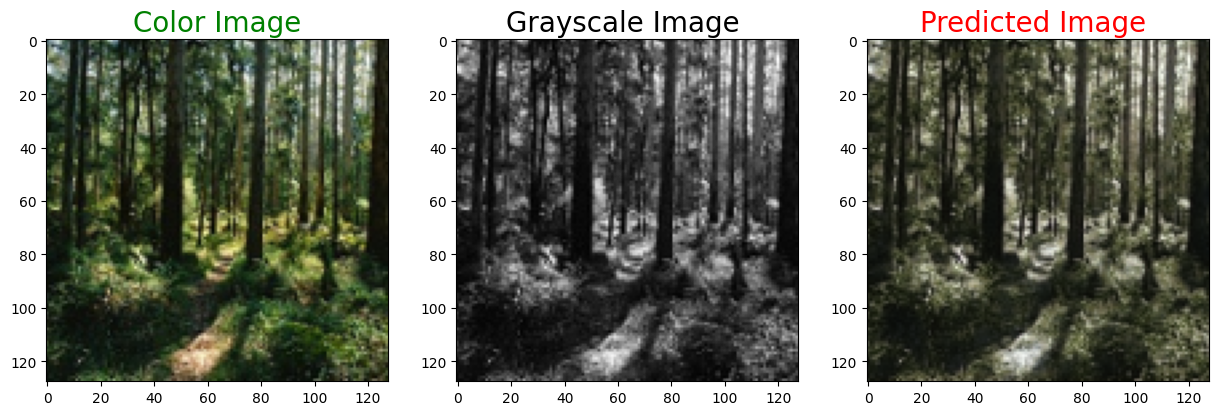

In [61]:
(gs_img, rgb_img), _ = val_set[300]
predicted = model(gs_img.unsqueeze(0).to(device))[0].cpu().detach()

plot_images(rgb_img.permute(1, 2, 0), gs_img.permute(1, 2, 0), predicted.permute(1, 2, 0))